<a href="https://colab.research.google.com/github/jvallikivi/mlmi4-vcl/blob/main/GREPLAY_Generative_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence, Normal
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.001
batch_size = 50
n_epochs = 200

In [39]:
class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_loc = nn.Parameter(torch.zeros(in_features, out_features))
        self.log_weight_scale = nn.Parameter(torch.zeros(in_features, out_features))

        self.bias_loc = nn.Parameter(torch.zeros(out_features))
        self.log_bias_scale = nn.Parameter(torch.zeros(out_features))
        
        self.weight = self.weight_loc.data.clone().to(device)
        self.bias = self.bias_loc.data.clone().to(device)



    def get_params(self):
        """
        return two tensors, obtaining by concatenating locs and scales together
        these parameters can be further used to calculate e.g, KL divergence (vectorizedly)
        """
        return (
                torch.cat([self.weight_loc.flatten(), self.bias_loc.flatten()]), 
                torch.cat([self.log_weight_scale.flatten(), self.log_bias_scale.flatten()])
               )

    
    def forward(self, x,  activition_fn=None):

        y = x @ self.weight + self.bias
        if activition_fn:
            return activition_fn(y)
        return y


In [40]:
class Encoder(nn.Module):

    def __init__(self, 
                 input_size, 
                 in_features, 
                 out_features, 
                 n_layers,                 ):
        """
        """
        super(Encoder, self).__init__()
        self.x_to_h = nn.ModuleList( [self.get_layer(input_size, in_features, True)] + 
                                    [self.get_layer(in_features, in_features, True) for _ in range(n_layers - 1)]).to(device)
        self.head = nn.ModuleList([self.get_layer(in_features, out_features, True) for _ in range(2)]).to(device)
                                    # + [self.get_layer(in_features, out_features)]).to(device)


    def get_layer(self, in_feature, out_features, activation=False):
        layer = nn.Linear(in_feature, out_features)
        return layer

In [41]:
class VCL_Generator(nn.Module):
    def __init__(self, previous_model, 
                 nencoder_layers=3, ndecoder_layers=1, 
                 z_dim=50, h_dim=500, x_dim=784, random_initialize=False):
        super().__init__()
        
        self.ndecoder_layers = ndecoder_layers
        self.z_dim = z_dim

        #######ENCODER PART

        self.encoder = Encoder(input_size=x_dim,
                                in_features=h_dim,
                                out_features=z_dim,
                                n_layers=nencoder_layers).to(device)
        self.x_to_h = self.encoder.x_to_h#.to(device)
        self.encoder_head = self.encoder.head#.to(device)

        ######GENERATOR PART


        self.decoder_head = nn.ModuleList([BayesLinear(z_dim, h_dim)] +
                                          [BayesLinear(h_dim, h_dim) for _ in range(self.ndecoder_layers)]).to(device) 
        self.h_to_x = nn.ModuleList([BayesLinear(h_dim, x_dim)]).to(device)
        
        
        # define a layer dict
        self.layer_dict = OrderedDict()
        for ix, layer in enumerate(self.x_to_h):
            self.layer_dict[f'x_to_h_{ix}'] = layer

        for ix, layer in enumerate(self.h_to_x):
            self.layer_dict[f'h_to_x_{ix}'] = layer
        
        for ix, layer in enumerate(self.decoder_head):
            self.layer_dict[f'decoder_head_{ix}'] = layer

        self.layer_dict["encoder_head"] = self.encoder_head

        # just a sanity check 
        assert id(self.layer_dict[f"x_to_h_{0}"]) == id(self.x_to_h[0])
        
        
        with torch.no_grad():
            if previous_model != None:
                for key in self.layer_dict:
                    if "decoder_head" in key or "h_to_x" in key:
                        self.layer_dict[key].weight_loc.data = previous_model.layer_dict[key].weight_loc.data.clone()
                        self.layer_dict[key].bias_loc.data = previous_model.layer_dict[key].bias_loc.data.clone()
                        self.layer_dict[key].log_weight_scale.data  = previous_model.layer_dict[key].log_weight_scale.data.clone()
                        self.layer_dict[key].log_bias_scale.data  = previous_model.layer_dict[key].log_bias_scale.data.clone()
                    else:
                        self.layer_dict[key] = previous_model.layer_dict[key]
            if random_initialize:
                for layer in self.h_to_x + self.decoder_head:
                    layer.log_weight_scale = nn.Parameter(torch.ones(layer.log_weight_scale.shape, device=device) * -6)
                    layer.log_bias_scale = nn.Parameter(torch.ones(layer.log_bias_scale.shape, device=device) * -6)
                    torch.nn.init.xavier_uniform_(layer.weight_loc)
        
        if  previous_model != None:
            previous_locs, previous_logscales = previous_model.get_params()
            self.previous_model_locs = previous_locs
            self.previous_model_log_scales = previous_logscales
        else:
            self.previous_model_locs = None
            self.previous_model_log_scales = None


    def encoder_forward(self, x):
        for layer in self.x_to_h:
            x = layer(x)
            x = nn.ReLU()(x)
        loc = self.encoder_head[0](x)
        log_scale = self.encoder_head[1](x)
        return loc, log_scale

    
    def decoder_forward(self, z, sampling=False):
        size = len(self.decoder_head + self.h_to_x)
        
        for ix, layer in enumerate(self.decoder_head + self.h_to_x):
            if sampling:
                layer.weight = torch.randn_like(layer.weight_loc) * torch.exp(layer.log_weight_scale) + layer.weight_loc
                layer.bias = torch.randn_like(layer.bias_loc) * torch.exp(layer.log_bias_scale) + layer.bias_loc
            z = layer(z, nn.Sigmoid())
        return z


    def get_params(self):  
        locs = []
        logscales = []
        for layer in self.h_to_x:
            loc, scale = layer.get_params()
            locs.append(loc)
            logscales.append(scale)
        return locs, logscales

    # def generate(self, head, generator)

            # for layer in generator:
                # z = layer.forward(z, nn.Sigmoid())

    def calculate_loss(self, x, y, heads=None, tails=None, 
                       n_particles=10, dataset_size=6000,
                       sample_size=100):
        
        locs, logscales = self.get_params()
        # calculate KL between "prior" and posterior
        size = len(locs)
        kl = 0
        for ix in range(size):
            KL = kl_divergence(Normal(loc=locs[ix], scale=torch.exp(logscales[ix])),
                                Normal(loc=self.previous_model_locs[ix], scale=torch.exp(self.previous_model_log_scales[ix]))
                            )
            kl += KL.sum()/dataset_size 

        loc, log_scale = self.encoder_forward(x) 
        kl_z = kl_divergence(Normal(loc, torch.exp(log_scale)), 
                             Normal(0., torch.exp(torch.Tensor([0.]).to(device))))
        bce = 0.
        gr = 0.     
        size = 0.
        if heads:
            for ix, head in enumerate(heads):
                head_o = torch.randn(sample_size, batch_size, 50).to(device)
                for layer in head:
                    head_o = layer.forward(head_o, nn.Sigmoid())
                
                gen_o1 = head_o
                gen_o2 = head_o
                for n, layer in enumerate(tails[ix]):
                    gen_o1 = layer.forward(gen_o1, nn.Sigmoid())
                    gen_o2 = self.h_to_x[n].forward(gen_o2, nn.Sigmoid())

                gr += torch.nn.functional.binary_cross_entropy(input=gen_o2, target=gen_o1, reduction="sum")
                size += 1
            # for layer in self.previous_model.decoder_head:
            #     head_o = layer.forward(head_o, nn.Sigmoid())
            # gen_o1 = head_o
            # for layer in self.previous_model.h_to_x:
            #     gen_o1 = layer.forward(gen_o1, nn.Sigmoid())

            # gen_o2 = head_o
            # for layer in self.h_to_x:
                # gen_o2 = layer.forward(head_o, nn.Sigmoid())

            # gr = torch.nn.functional.binary_cross_entropy(input=gen_o2, target=gen_o1, reduction="sum")
        
        for _ in range(n_particles):
            z = torch.randn_like(loc) * torch.exp(log_scale) + loc
            gen = self.decoder_forward(z, sampling=True)
            bce = bce + torch.nn.functional.binary_cross_entropy(input=gen, target=x, reduction="sum")
            

        loss = (kl_z.sum() + (bce / n_particles + gr/sample_size)/(size + 1)) / x.shape[0] + kl
        return loss  

In [42]:
def greplay(model):
    with torch.no_grad():
        z = torch.randn(batch_size, 50).to(device)
        o = model.decoder_forward(z, sampling=False)
    return o

In [43]:
## dataset
ds_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
ds_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)

def get_digit(task_idx=0, conv=False):
    #image normalization 255
    train_y = torch.tensor([d[1] for d in ds_train])
    test_y = torch.tensor([d[1] for d in ds_test])

    train_mask = train_y == task_idx
    test_mask = test_y == task_idx

    train_y = train_y[train_mask]
    test_y = test_y[test_mask]

    test_x = nn.Flatten()(torch.cat([d[0] for d in ds_test]))[test_mask]
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train]))[train_mask]

    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

In [44]:
# I used their evaluation function and adjusted for torch for consistency
def gaussian_prob(x, loc=0., log_scale=torch.Tensor([0.]).to(device)):
    p1 = -torch.log(torch.Tensor([2 * torch.pi]).to(device))/2 + log_scale
    p2 = -((x - loc)/(2*(torch.exp(log_scale))))**2
    prob = (p1 + p2).sum(1) 
    return prob


def bernoulli_prob(x, p=torch.Tensor([0.5]).to(device)):
    p1 = x * torch.log(torch.clamp(p, 1e-9, 1.0))
    p2 = (1 - x) * torch.log(torch.clamp(1.0 - p, 1e-9, 1.0))
    prob = (p1 + p2).sum(1)

    return prob

def evaluate(model, test_batch):
    test_batch = test_batch.repeat(100, 1)
    loc, log_scale = model.encoder_forward(test_batch) 
    z = torch.randn_like(loc) * torch.exp(log_scale) + loc
    gen = model.decoder_forward(z, sampling=True)
    kl =  gaussian_prob(z, loc, log_scale) - gaussian_prob(z)
    bce = bernoulli_prob(test_batch, gen)
    test_ll = (bce - kl).reshape((100, batch_size))
    max = test_ll.max(0)[0]
    test_ll = torch.log(torch.clamp_min(torch.exp(test_ll - max).mean(0), 1e-9)) + max
    mean = test_ll.mean()
    var = ((test_ll - mean) ** 2).mean()
    return mean, var

In [45]:
%mkdir models

mkdir: cannot create directory ‘models’: File exists


100%|██████████| 200/200 [09:01<00:00,  2.71s/it]


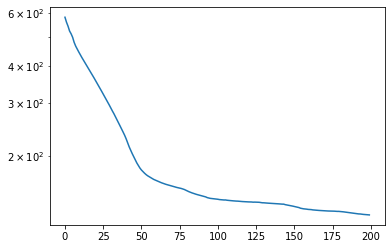

100%|██████████| 200/200 [11:23<00:00,  3.42s/it]


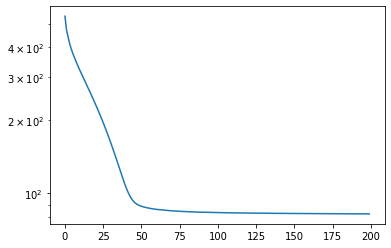

100%|██████████| 200/200 [11:34<00:00,  3.47s/it]


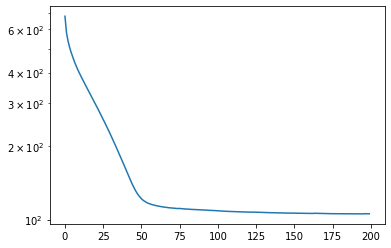

100%|██████████| 200/200 [13:36<00:00,  4.08s/it]


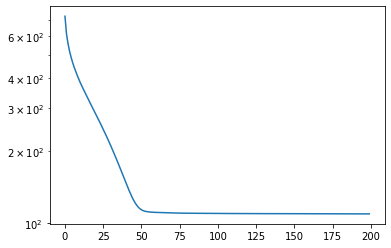

100%|██████████| 200/200 [15:01<00:00,  4.51s/it]


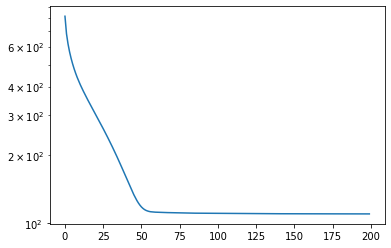

100%|██████████| 200/200 [15:45<00:00,  4.73s/it]


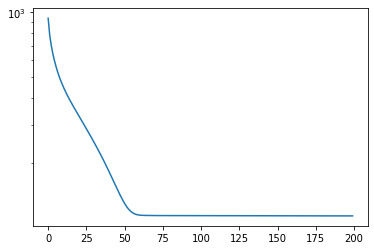

100%|██████████| 200/200 [19:32<00:00,  5.86s/it]


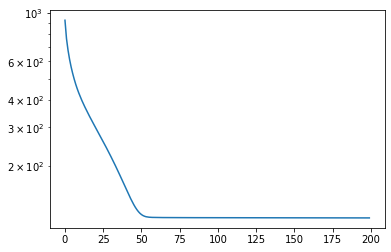

100%|██████████| 200/200 [22:58<00:00,  6.89s/it]


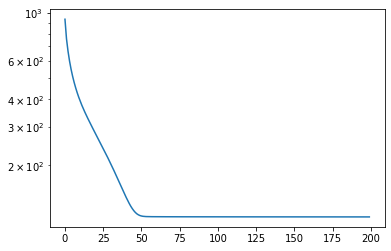

100%|██████████| 200/200 [23:58<00:00,  7.19s/it]


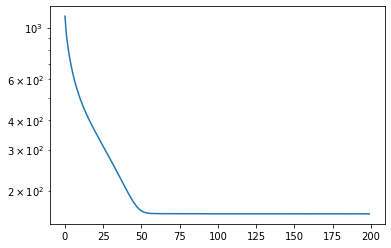

100%|██████████| 200/200 [26:05<00:00,  7.83s/it]


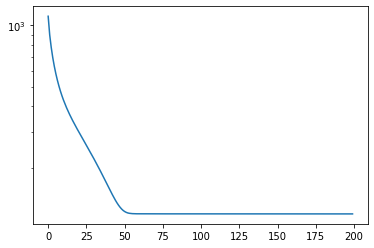

In [46]:
import copy
previous_model = VCL_Generator(previous_model=None).to(device) # initialize a prior model
lr = 0.001
models = []
heads = []
tails = []
for digit_id in range(10): #
    train_x, train_y, test_x, test_y = get_digit(digit_id)
    current_model = VCL_Generator(previous_model=previous_model, random_initialize=True).to(device)
    current_opt = torch.optim.Adam(current_model.parameters(), lr=lr)
    train_losses = []
    dataset_size = train_x.shape[0]
    nbatches = int(np.ceil(train_x.shape[0] / batch_size))



    for epoch in tqdm(range(n_epochs)):
        loss_batch = []
        for batch in range(nbatches):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            batch_x = train_x[batch_idx0: batch_idx1].to(device)
            batch_y = train_y[batch_idx0: batch_idx1].to(device)

            current_opt.zero_grad()
            ############ version 1 ################
            # if digit_id > 0:
            #     gener = greplay(previous_model)
            #     batch_x = torch.concat((batch_x, gener), 0)
            # loss = current_model.calculate_loss(x=batch_x, 
            #                                     y=batch_y, 
            #                                     n_particles=10,
            #                                     dataset_size=dataset_size
            #                                     )

            ############ version 2 ##############
            if digit_id > 0:

                loss = current_model.calculate_loss(x=batch_x, 
                                                    y=batch_y,
                                                    heads = heads,
                                                    tails = tails,
                                                    n_particles=10,
                                                    dataset_size=dataset_size
                                                    )
            else:
                loss = current_model.calculate_loss(x=batch_x, 
                                    y=batch_y,
                                    n_particles=10,
                                    dataset_size=dataset_size
                                    )

            loss.backward(retain_graph=True)
            nn.utils.clip_grad_value_(current_model.parameters(), 1)
            current_opt.step()
            loss_batch.append(loss.item())
        train_losses.append(np.mean(loss_batch))
    plt.plot(train_losses)
    plt.yscale("log")
    plt.show()
    models.append(copy.copy(current_model))
    torch.save(current_model.state_dict(), f"models/model_task{digit_id}")
    previous_model = current_model
    head = copy.copy(current_model.decoder_head)
    tail = copy.copy(current_model.h_to_x)

    # for param in head.parameters():
    #     param.requires_grad = False
    

    # for param in tail.parameters():
    #     param.requires_grad = False    


    for layer in head:
        layer.weight = layer.weight.detach()
        layer.bias = layer.bias.detach()
        
    for layer in tail:
        layer.weight = layer.weight.detach()
        layer.bias = layer.bias.detach()

    heads.append(head)
    tails.append(tail)

In [47]:
heads[0][0].weight.requires_grad

False

In [48]:
model0 = VCL_Generator(previous_model=None)
model0.load_state_dict(torch.load("models/model_task0"))
model0.eval()
_, _, test_x, _ = get_digit(0)
nbatches = test_x.shape[0] // batch_size
ll_total = 0.
for batch in range(nbatches):
    batch_idx0 = batch * batch_size
    batch_idx1 = batch * batch_size + batch_size
    ll, _ = evaluate(model0, test_x[batch_idx0: batch_idx1].to(device))
    ll_total += ll/nbatches

In [49]:
ll_total

tensor(-91.0151, device='cuda:0', grad_fn=<AddBackward0>)

In [50]:
import copy
def calculate_digit_ll(digit_num):
    lls = []
    try:

        _, _, test_x, _ = get_digit(digit_num)

        model = VCL_Generator(previous_model=None)
        model.load_state_dict(torch.load(f"models/model_task{digit_num}"))
        nbatches = test_x.shape[0] // batch_size
        ll_total = 0.
        for batch in range(nbatches):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            ll, _ = evaluate(model, test_x[batch_idx0: batch_idx1])
            ll_total += ll/nbatches

        lls.append(ll_total.detach().item())
        # print(ll_total)
        for i in range(digit_num+1, 10, 1):
            model1 = VCL_Generator(previous_model=None)
            model1.load_state_dict(torch.load(f"models/model_task{i}"))
            model.h_to_x = copy.copy(model1.h_to_x)
            ll_total = 0.
            for batch in range(nbatches):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                ll, _ = evaluate(model, test_x[batch_idx0: batch_idx1])
                ll_total += ll/nbatches
            lls.append(ll_total.detach().item())    
        # print(ll_total)
    except:
        pass

    return lls

In [51]:
from collections import defaultdict
test_ll_dict = defaultdict(list)
for i in tqdm(range(10)):
    test_ll_dict[i] = calculate_digit_ll(i)

100%|██████████| 10/10 [02:36<00:00, 15.68s/it]


In [52]:
test_ll_dict

defaultdict(list,
            {0: [-91.04664611816406,
              -91.72366333007812,
              -91.4623794555664,
              -91.1744384765625,
              -90.8778076171875,
              -90.86552429199219,
              -90.75572967529297,
              -90.65145874023438,
              -90.586669921875,
              -90.57637023925781],
             1: [-39.81670379638672,
              -39.953025817871094,
              -39.86759567260742,
              -39.804298400878906,
              -39.67119216918945,
              -39.65776443481445,
              -39.62031555175781,
              -39.604759216308594,
              -39.524322509765625],
             2: [-118.89160919189453,
              -119.13859558105469,
              -118.99658966064453,
              -118.83584594726562,
              -118.62954711914062,
              -118.49301147460938,
              -118.49653625488281,
              -118.54464721679688],
             3: [-112.10735321044922,
       

In [53]:
def generate_image(head, generator, z):
    with torch.no_grad():
        for layer in head:
            z = layer.forward(z, nn.Sigmoid())
        for layer in generator:
            z = layer.forward(z, nn.Sigmoid())
    z = z.detach().cpu()
    n_digits = int(z.shape[0] ** .5)
    if n_digits > 1:
        z =  z.reshape((n_digits, n_digits, 28, 28))
        image = np.concatenate([el for el in z], axis=-1)
        image = np.concatenate([el for el in image], axis=0)    
    else:
        image = z.reshape((28, 28))
    return image

In [54]:
len(models)

10

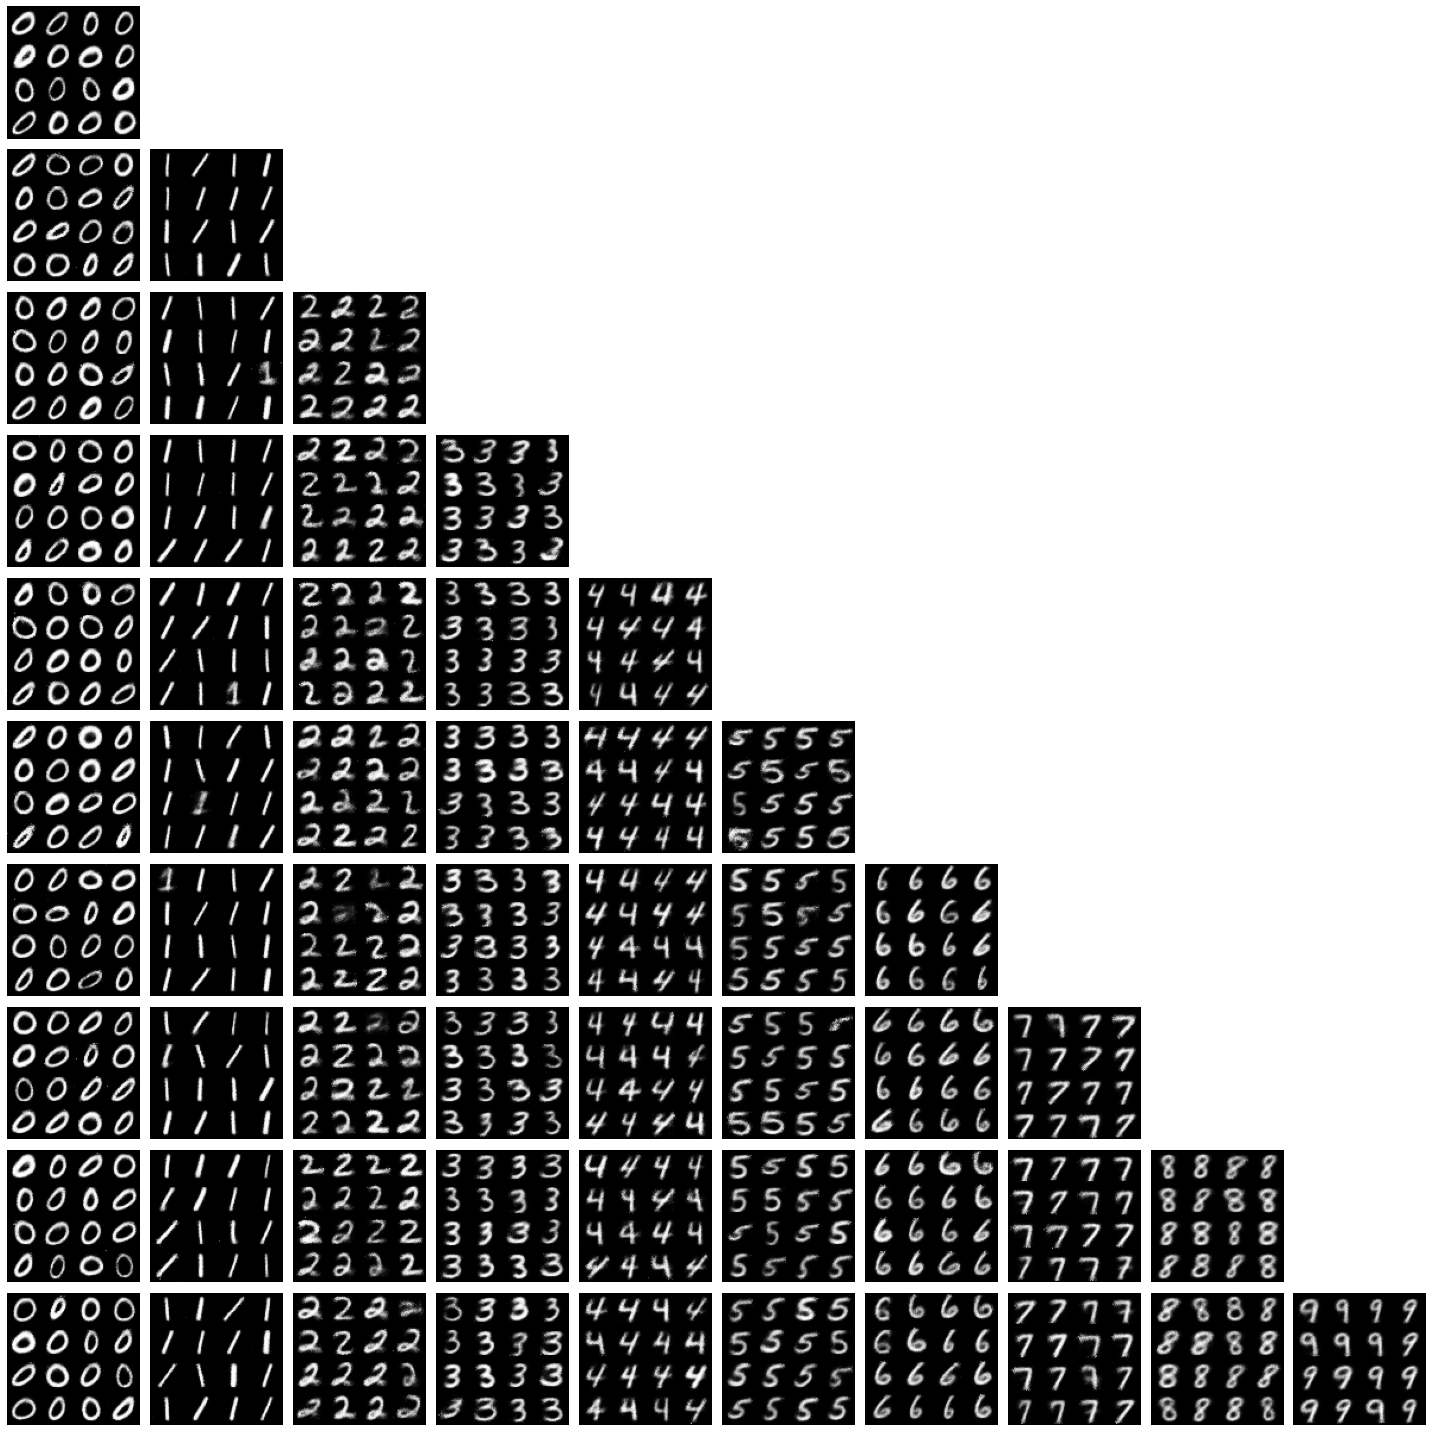

In [55]:
nrows, ncols = 10, 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].axis('off')
fig.tight_layout()
for ix1, model1 in enumerate(models):
    cnt = 0
    z = torch.randn(16, 50).to(device)
    image = generate_image(model1.decoder_head, model1.h_to_x, z)
    axes[cnt+ix1, ix1].imshow(image, cmap="gray")
    axes[cnt+ix1, ix1].axis('off')

    for ix2, model2 in enumerate(models[ix1+1:]):
        cnt += 1
        z = torch.randn(16, 50).to(device)
        image = generate_image(model1.decoder_head, model2.h_to_x, z)
        axes[cnt+ix1, ix1].imshow(image, cmap="gray")
        axes[cnt+ix1, ix1].axis('off')

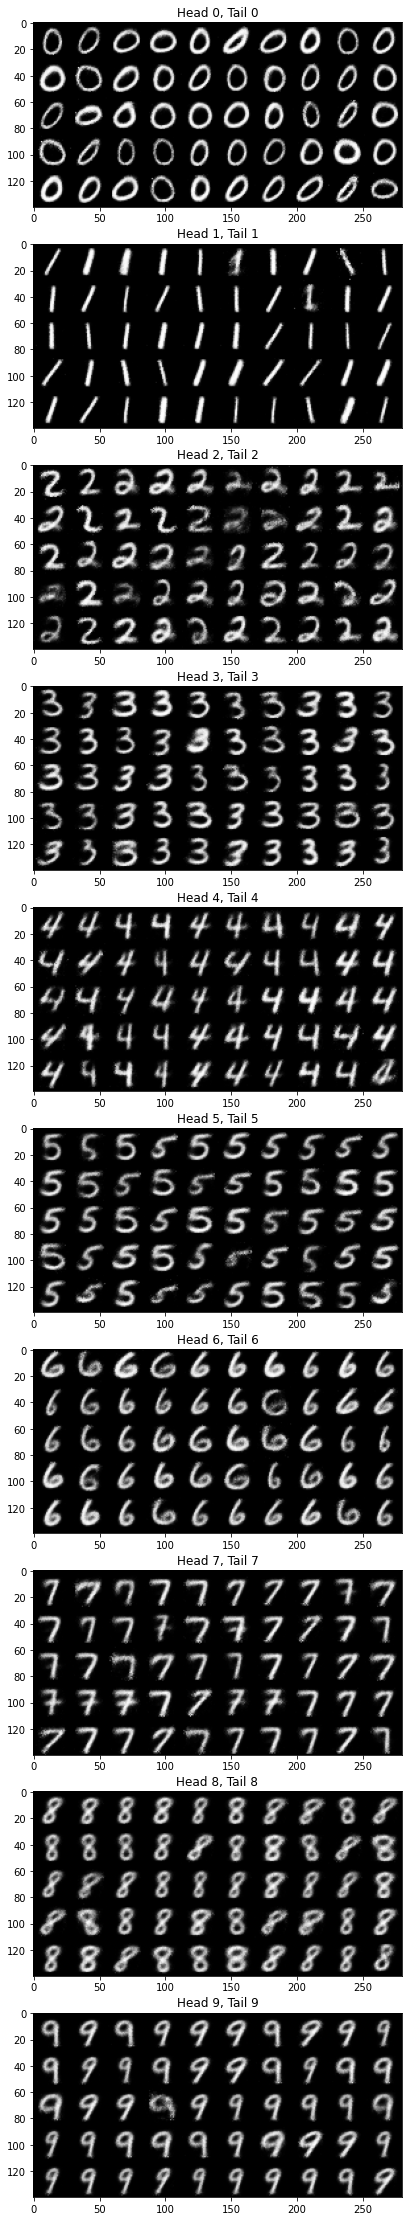

In [69]:
sample_size = 100
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(20, 40))
for ix, head in enumerate(heads):
    head_o = torch.randn(sample_size, batch_size, 50).to(device)
    for layer in head:
        head_o = layer.forward(head_o, nn.Sigmoid())

    gen_o1 = head_o
    for n, layer in enumerate(tails[ix]):
        gen_o1 = layer.forward(gen_o1, nn.Sigmoid())

    rand_id = np.random.choice(sample_size)
    gen_o = gen_o1[rand_id].detach().cpu().reshape((10, 5, 28, 28))
    image = np.concatenate([el for el in gen_o], axis=-1)
    image = np.concatenate([el for el in image], axis=0)  

    axes[ix].imshow(image, cmap="gray")
    axes[ix].set_title(f"Head {ix}, Tail {ix}")